In [1]:
import os
import cv2
import pydicom
import glob

import pandas as pd
import numpy as np
import matplotlib.image as mpimg
import seaborn as sns
import matplotlib.pyplot as plt

from tqdm import tqdm
from PIL import Image, ImageDraw, ImageFont

In [11]:
# Directories

dir_dcm = '../stage2/stage_2_train_images/'
dir_img = '../stage2/train512/'


In [4]:
df = pd.read_csv('../train.csv')

In [5]:
df.head()

,name,epidural,intraparenchymal,intraventricular,subarachnoid,subdural,any
0,ID_63eb1e259,0,0,0,0,0,0
1,ID_2669954a7,0,0,0,0,0,0
2,ID_52c9913b1,0,0,0,0,0,0
3,ID_4e6ff6126,0,0,0,0,0,0
4,ID_7858edd88,0,0,0,0,0,0


In [6]:
print('Epidural: ',np.sum(df['epidural']))
print('Intraparenchymal: ',np.sum(df['intraparenchymal']))
print('Intraventricular: ',np.sum(df['intraventricular']))
print('Subarachnoid: ',np.sum(df['subarachnoid']))
print('Subdural: ',np.sum(df['subdural']))
print('Any: ',np.sum(df['any']))

Epidural:  2761
Intraparenchymal:  32564
Intraventricular:  23766
Subarachnoid:  32122
Subdural:  42496
Any:  97103


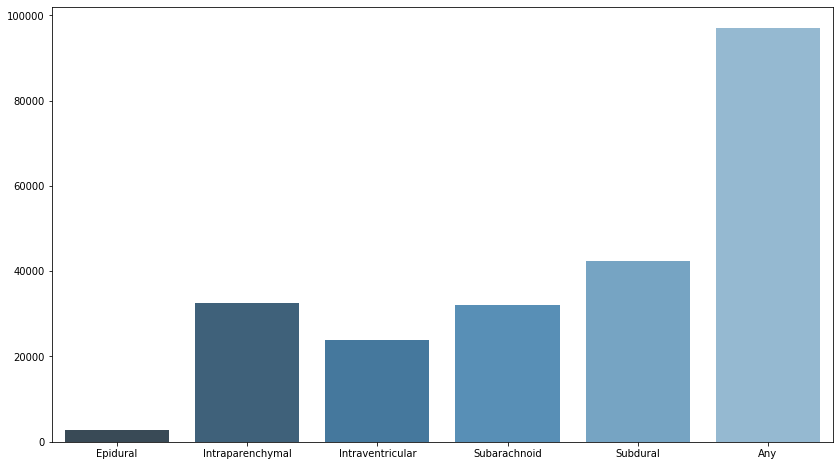

In [7]:
#plt.hist(['Epidural','Intraparenchymal','Intraventricular','Subarachnoid','Subdural','Any'], [np.sum(df['epidural']),np.sum(df['intraparenchymal']),np.sum(df['intraventricular']),np.sum(df['subarachnoid']),np.sum(df['subdural']),np.sum(df['any'])])
fig, ax = plt.subplots(figsize=(14,8))

sns.barplot(
    x=['Epidural','Intraparenchymal','Intraventricular','Subarachnoid','Subdural','Any'],
    y=[np.sum(df['epidural']),np.sum(df['intraparenchymal']),np.sum(df['intraventricular']),np.sum(df['subarachnoid']),np.sum(df['subdural']),np.sum(df['any'])],
    ax=ax,
    palette="Blues_d"
)

In [8]:
# The following script was used to generate the images in this dataset
# Note that a small number of images failed due to issues with the pixel data

# Functions

def window_image(img, window_center, window_width, intercept, slope):
    """
    https://www.kaggle.com/omission/eda-view-dicom-images-with-correct-windowing
    """
    img = (img * slope + intercept)
    img_min = window_center - window_width // 2
    img_max = window_center + window_width // 2
    img[img < img_min] = img_min
    img[img > img_max] = img_max

    return img


def get_first_of_dicom_field_as_int(x):
    """
    https://www.kaggle.com/omission/eda-view-dicom-images-with-correct-windowing
    """
    # get x[0] as in int is x is a 'pydicom.multival.MultiValue', otherwise get int(x)
    if type(x) == pydicom.multival.MultiValue:
        return int(x[0])
    else:
        return int(x)


def get_windowing(data):
    """
    https://www.kaggle.com/omission/eda-view-dicom-images-with-correct-windowing
    """
    dicom_fields = [data[('0028', '1050')].value,  # window center
                    data[('0028', '1051')].value,  # window width
                    data[('0028', '1052')].value,  # intercept
                    data[('0028', '1053')].value]  # slope
    return [get_first_of_dicom_field_as_int(x) for x in dicom_fields]

def convert_to_png(dcm_in):

    dcm = pydicom.dcmread(dcm_in)
    window_center, window_width, intercept, slope = get_windowing(dcm)
    img = pydicom.read_file(dcm_in).pixel_array
    img = window_image(img, window_center, window_width, intercept, slope)
    #cv2.imwrite(os.path.join(dir_img, os.path.basename(dcm_in)[:-3] + 'png'), img)
    return img


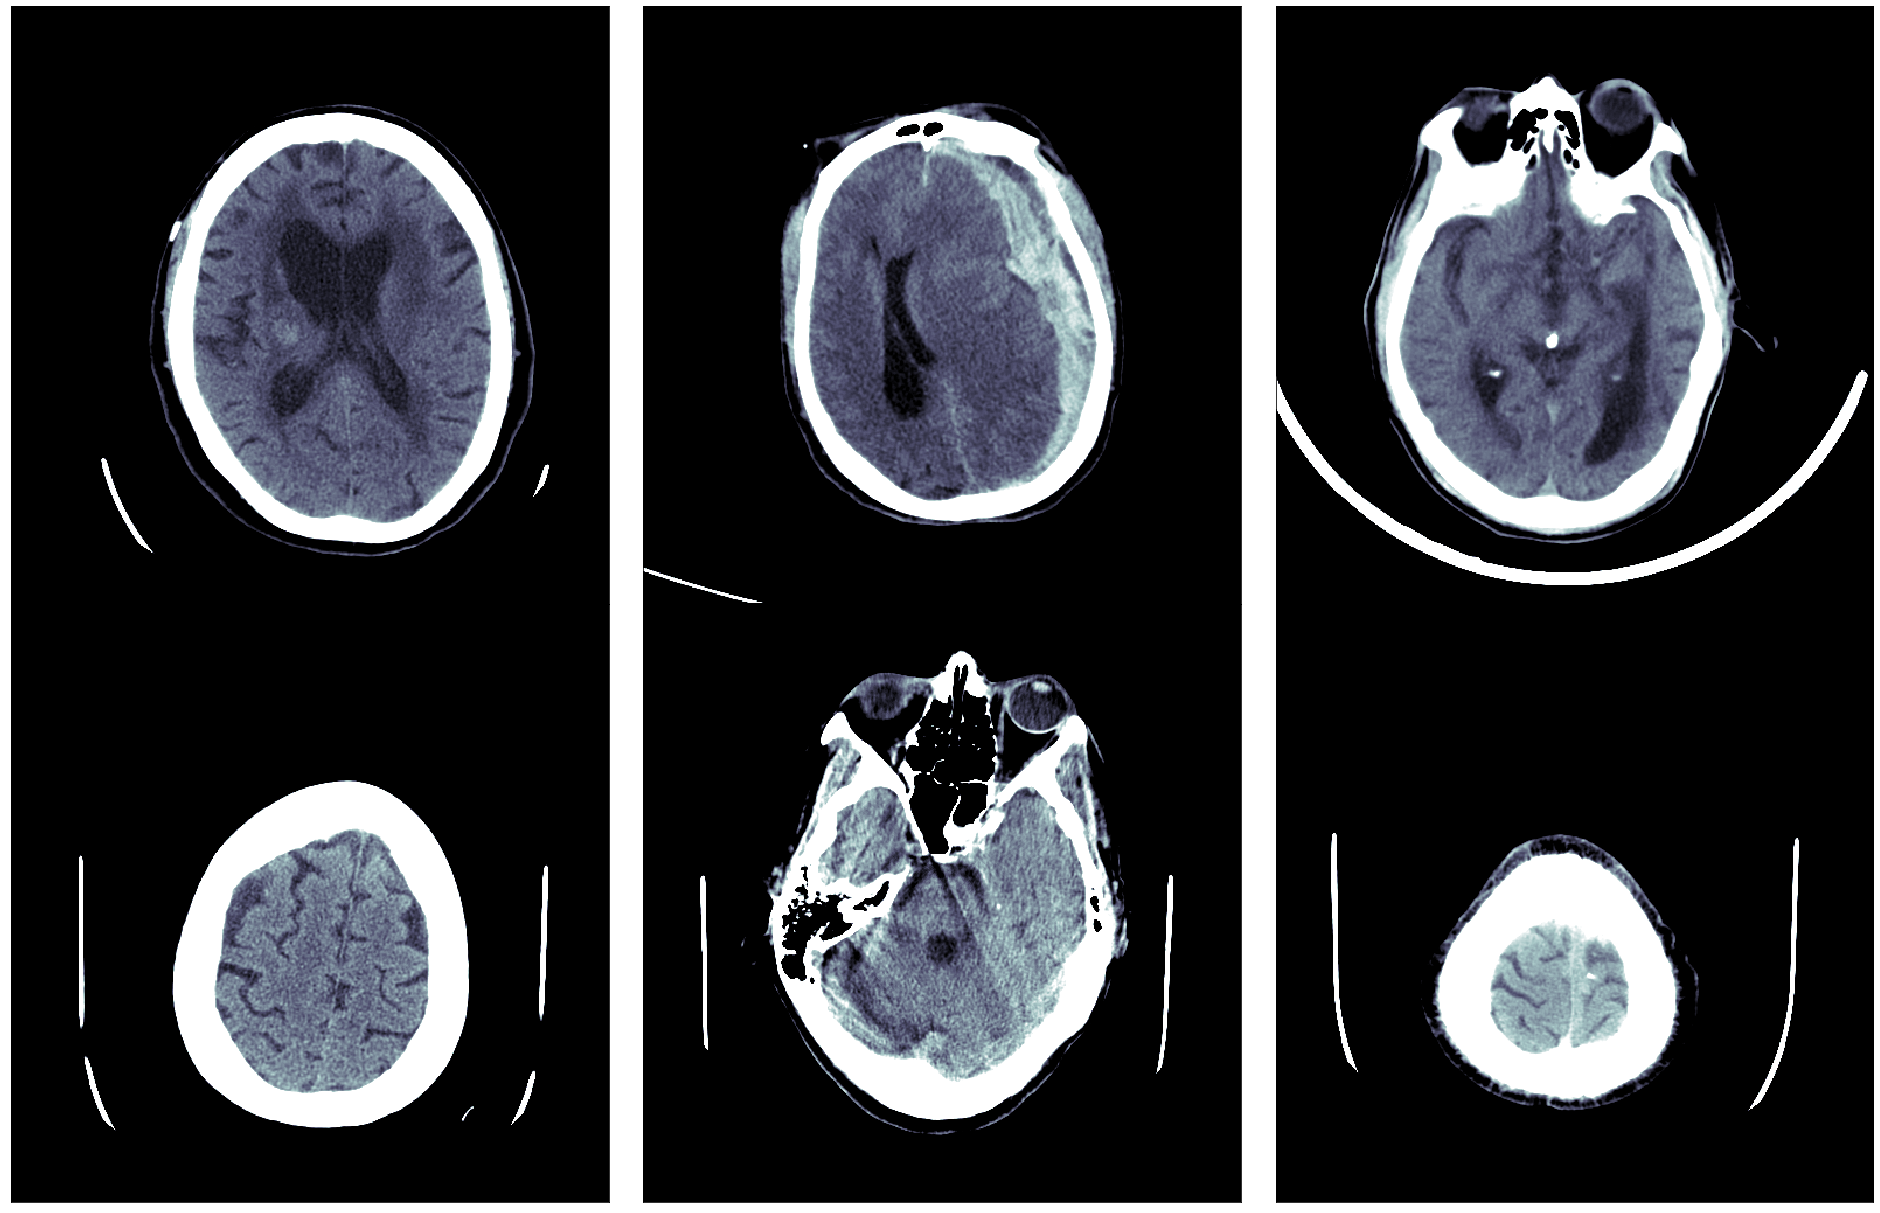

In [15]:
dicom_info = False

dicom_files = os.listdir(dir_dcm)

fig=plt.figure(figsize=(34, 22))
columns = 3; rows = 2
for i in range(1, columns*rows +1):
    dcm = dir_dcm + dicom_files[i]
    dicom = pydicom.dcmread(dcm)
    ds1 = convert_to_png(dcm)
    ds = Image.fromarray(ds1)
    ds_ = ImageDraw.Draw(ds)
    content = ''
    for j in list(dicom.keys())[:-1]:
        content += '%s: %s \n'%(dicom[j].name, dicom[j].value)
    if not dicom_info:
        content=''
    ds_.text(
        (10,10),
        "%s"%(content),fill=65,
        font = ImageFont.truetype(
            '/usr/share/fonts/truetype/ubuntu-font-family/UbuntuMono-R.ttf',
            12
        )
    )
    ds = np.array(ds)

    cv2.imwrite('./display/' + dicom_files[i].split('.')[0] + '.jpg', ds)
    fig.add_subplot(rows, columns, i)
    plt.xticks([])
    plt.yticks([])
    plt.subplots_adjust(wspace =0, hspace =0)
    plt.imshow(ds, cmap=plt.cm.bone)
    fig.add_subplot